# setup and imports

In [80]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [82]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/HISTOLOGY"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')
animalList = glob.glob(root+"/*")

Path to data is: /home/david/Desktop/HISTOLOGY
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 7 rats in the data folder


In [208]:

animalList = ['RatF30', 'RatF31', 'RatM30', 'RatF40', 'RatF41', 'RatM41', 'RatM42',
            #    'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52'
               ]

In [209]:
import csv

def read_ROI_from_csv(file_path):
    ROI = []
    try:
        with open(file_path, mode='r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                if len(row) == 2:
                    try:
                        x = round(float(row[0]))
                        y = round(float(row[1]))
                        ROI.append((x, y))
                    except ValueError:
                        if row[0] == 'X' and row[1] == 'Y':
                            continue
                        else:
                            print(f"Skipping invalid row: {row}")
                else:
                    print(f"Skipping row with incorrect number of columns: {row}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while reading the file: {str(e)}")

    return np.array(ROI)

def compute_area(ROI):
    '''Compute the area of a polygonal ROI using the shoelace formula'''
    n = len(ROI)
    area = 0.0

    for i in range(n):
        x1, y1 = ROI[i]
        x2, y2 = ROI[(i + 1) % n]
        area += (x1 * y2 - x2 * y1)

    area = abs(area) / 2.0
    return area

def compute_centroid(ROI):
    '''Compute the centroid of a polygonal ROI using the shoelace formula'''
    n = len(ROI)
    if n == 0:
        return None

    sum_x = 0
    sum_y = 0
    signed_area = 0

    for i in range(n):
        x1, y1 = ROI[i]
        x2, y2 = ROI[(i + 1) % n]  # Wrap around for the last point

        cross_product = (x1 * y2 - x2 * y1)
        signed_area += cross_product
        sum_x += (x1 + x2) * cross_product
        sum_y += (y1 + y2) * cross_product

    signed_area /= 2.0
    centroid_x = sum_x / (6 * signed_area)
    centroid_y = sum_y / (6 * signed_area)

    return (centroid_x, centroid_y)

lesion_area = {animal: [] for animal in animalList}
shifts = {animal: [] for animal in animalList}
for animal in animalList:
    print(animal)
    animalFolder = root + '/' + animal
    slices = glob.glob(animalFolder + '/*.czi')
    for i, slice in enumerate(slices):
        print(slice)
        ROI_Left_Striatum = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')
        ROI_Right_Striatum = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')
        ROI_Left_Lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')
        ROI_Right_Lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')


        AREA_Left_Striatum = compute_area(ROI_Left_Striatum)
        AREA_Right_Striatum = compute_area(ROI_Right_Striatum)
        AREA_Left_Lesion = compute_area(ROI_Left_Lesion)
        AREA_Right_Lesion = compute_area(ROI_Right_Lesion)

        CENTROID_Left_Striatum, _ = compute_centroid(ROI_Left_Striatum)
        CENTROID_Right_Striatum, _ = compute_centroid(ROI_Right_Striatum)
        CENTROID_Left_Lesion, _ = compute_centroid(ROI_Left_Lesion)
        CENTROID_Right_Lesion, _ = compute_centroid(ROI_Right_Lesion)

        RATIO_Left = AREA_Left_Lesion / AREA_Left_Striatum
        RATIO_Right = AREA_Right_Lesion / AREA_Right_Striatum
        lesion_area[animal].extend((RATIO_Left, RATIO_Right))

        # mediolateralily
        XSHIFT_Left = CENTROID_Left_Lesion - CENTROID_Left_Striatum
        XSHIFT_Right = CENTROID_Right_Lesion - CENTROID_Right_Striatum
        print(f"Left: {-XSHIFT_Left:.2f}, Right: {XSHIFT_Right:.2f}")
        shifts[animal].extend((-XSHIFT_Left, XSHIFT_Right))

lesion_area = {animal: np.mean(lesion_area[animal]) for animal in animalList}
lesion_pos = {animal: np.mean(shifts[animal]) for animal in animalList}

RatF30
/home/david/Desktop/HISTOLOGY/RatF30/slice3.czi
Left: 463.27, Right: 338.50
/home/david/Desktop/HISTOLOGY/RatF30/slice5.czi
Left: 205.42, Right: 175.84
/home/david/Desktop/HISTOLOGY/RatF30/slice8.czi
Left: -215.05, Right: -93.73
RatF31
/home/david/Desktop/HISTOLOGY/RatF31/slice2.czi
Left: 351.72, Right: 330.97
/home/david/Desktop/HISTOLOGY/RatF31/slice5.czi
Left: 274.32, Right: 319.57
/home/david/Desktop/HISTOLOGY/RatF31/slice8.czi
Left: 350.64, Right: 135.68
RatM30
/home/david/Desktop/HISTOLOGY/RatM30/slice2.czi
Left: -243.32, Right: 184.30
/home/david/Desktop/HISTOLOGY/RatM30/slice5.czi
Left: 48.28, Right: 36.23
/home/david/Desktop/HISTOLOGY/RatM30/slice9.czi
Left: -55.50, Right: -186.58
RatF40
/home/david/Desktop/HISTOLOGY/RatF40/slice8.czi
Left: -430.27, Right: -556.07
/home/david/Desktop/HISTOLOGY/RatF40/slice6.czi
Left: -250.95, Right: -529.76
/home/david/Desktop/HISTOLOGY/RatF40/slice4.czi
Left: -559.52, Right: -203.66
RatF41
/home/david/Desktop/HISTOLOGY/RatF41/slice9.cz

(0.0, 45.0)

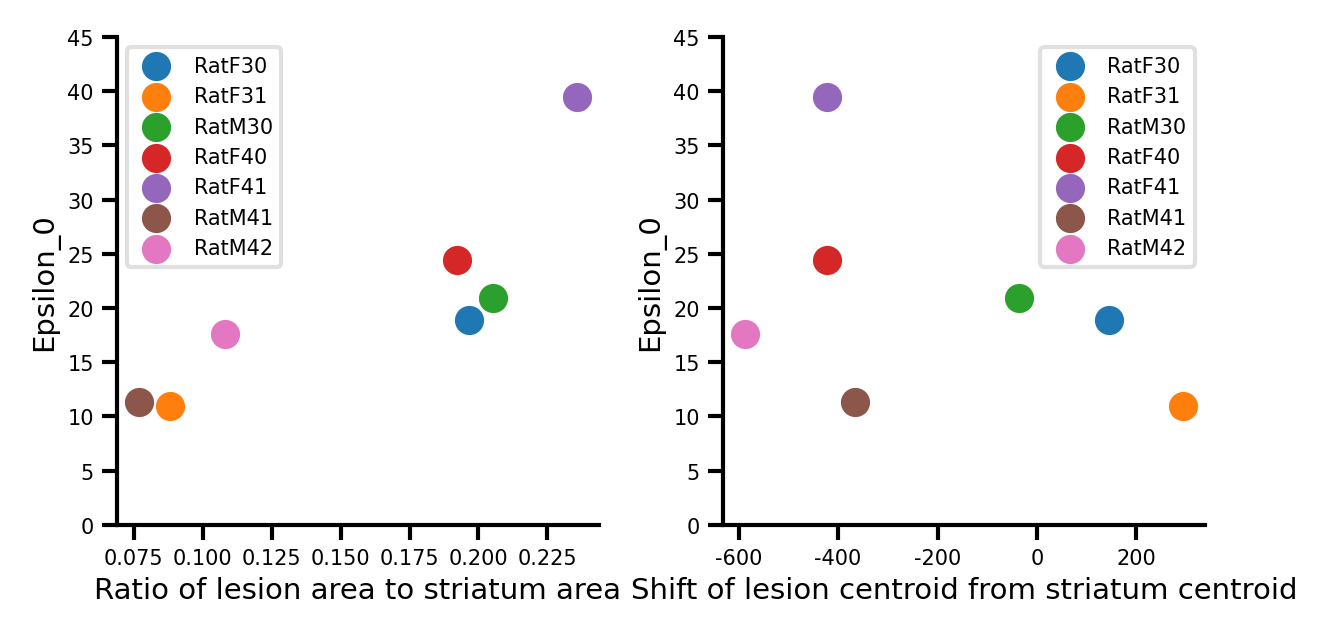

In [210]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
for animal in animalList:
    axs[0].scatter(avg[animal], epsilon_0[animal], label=animal)
    axs[1].scatter(avgshift[animal], epsilon_0[animal], label=animal)

axs[0].set_xlabel('Ratio of lesion area to striatum area')
axs[0].set_ylabel('Epsilon_0')
axs[0].legend()
axs[0].set_ylim(0, 45)

axs[1].set_xlabel('Shift of lesion centroid from striatum centroid')
axs[1].set_ylabel('Epsilon_0')
axs[1].legend()
axs[1].set_ylim(0, 45)

(-0.01, 0.35)

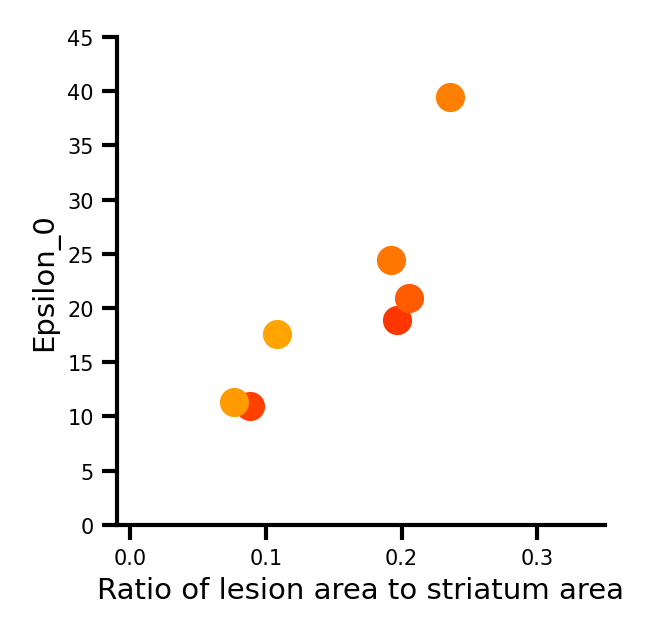

In [276]:
fig, ax = plt.subplots(figsize=(2, 2))
for animal in animalList:
    try:
        ax.scatter(lesion_area[animal], epsilon_0[animal], label=animal, color=rat_markers[animal][0])
    except KeyError:
        # ax.scatter(0, epsilon_0[animal], label=animal, color=rat_markers[animal][0])
        pass


ax.set_xlabel('Ratio of lesion area to striatum area')
ax.set_ylabel('Epsilon_0')
# ax.legend()
ax.set_ylim(0, 45)
ax.set_xlim(-.01, 0.35)

In [268]:
lesion_area = pickle.load(open('picklejar/lesion_size', 'rb'))
# pickle.dump(lesion_area, open('picklejar/lesion_size', 'wb'))
lesion_area

{'RatF30': 0.19643901165126965,
 'RatF31': 0.08821956560196688,
 'RatM30': 0.2053259666773024,
 'RatF40': 0.19233649612363857,
 'RatF41': 0.23575508839542056,
 'RatM41': 0.07675401050733947,
 'RatM42': 0.10798724059249032}

epsilon_0 corr: 0.84, p: 0.0193
epsilon_t corr: 0.70, p: 0.0791
epsilon_R corr: 0.59, p: 0.1644
alpha_0 corr: 0.43, p: 0.3312
alpha_t corr: -0.78, p: 0.0366
alpha_R corr: -0.01, p: 0.9746
gamma_0 corr: -0.59, p: 0.1612
gamma_t corr: -0.12, p: 0.8018
gamma_R corr: 0.64, p: 0.1235
mu_0 corr: 0.89, p: 0.0069
mu_t corr: 0.17, p: 0.7103
mu_R corr: 0.48, p: 0.2805
sigma_0 corr: 0.84, p: 0.0176
sigma_t corr: 0.28, p: 0.5436
sigma_R corr: 0.36, p: 0.4307


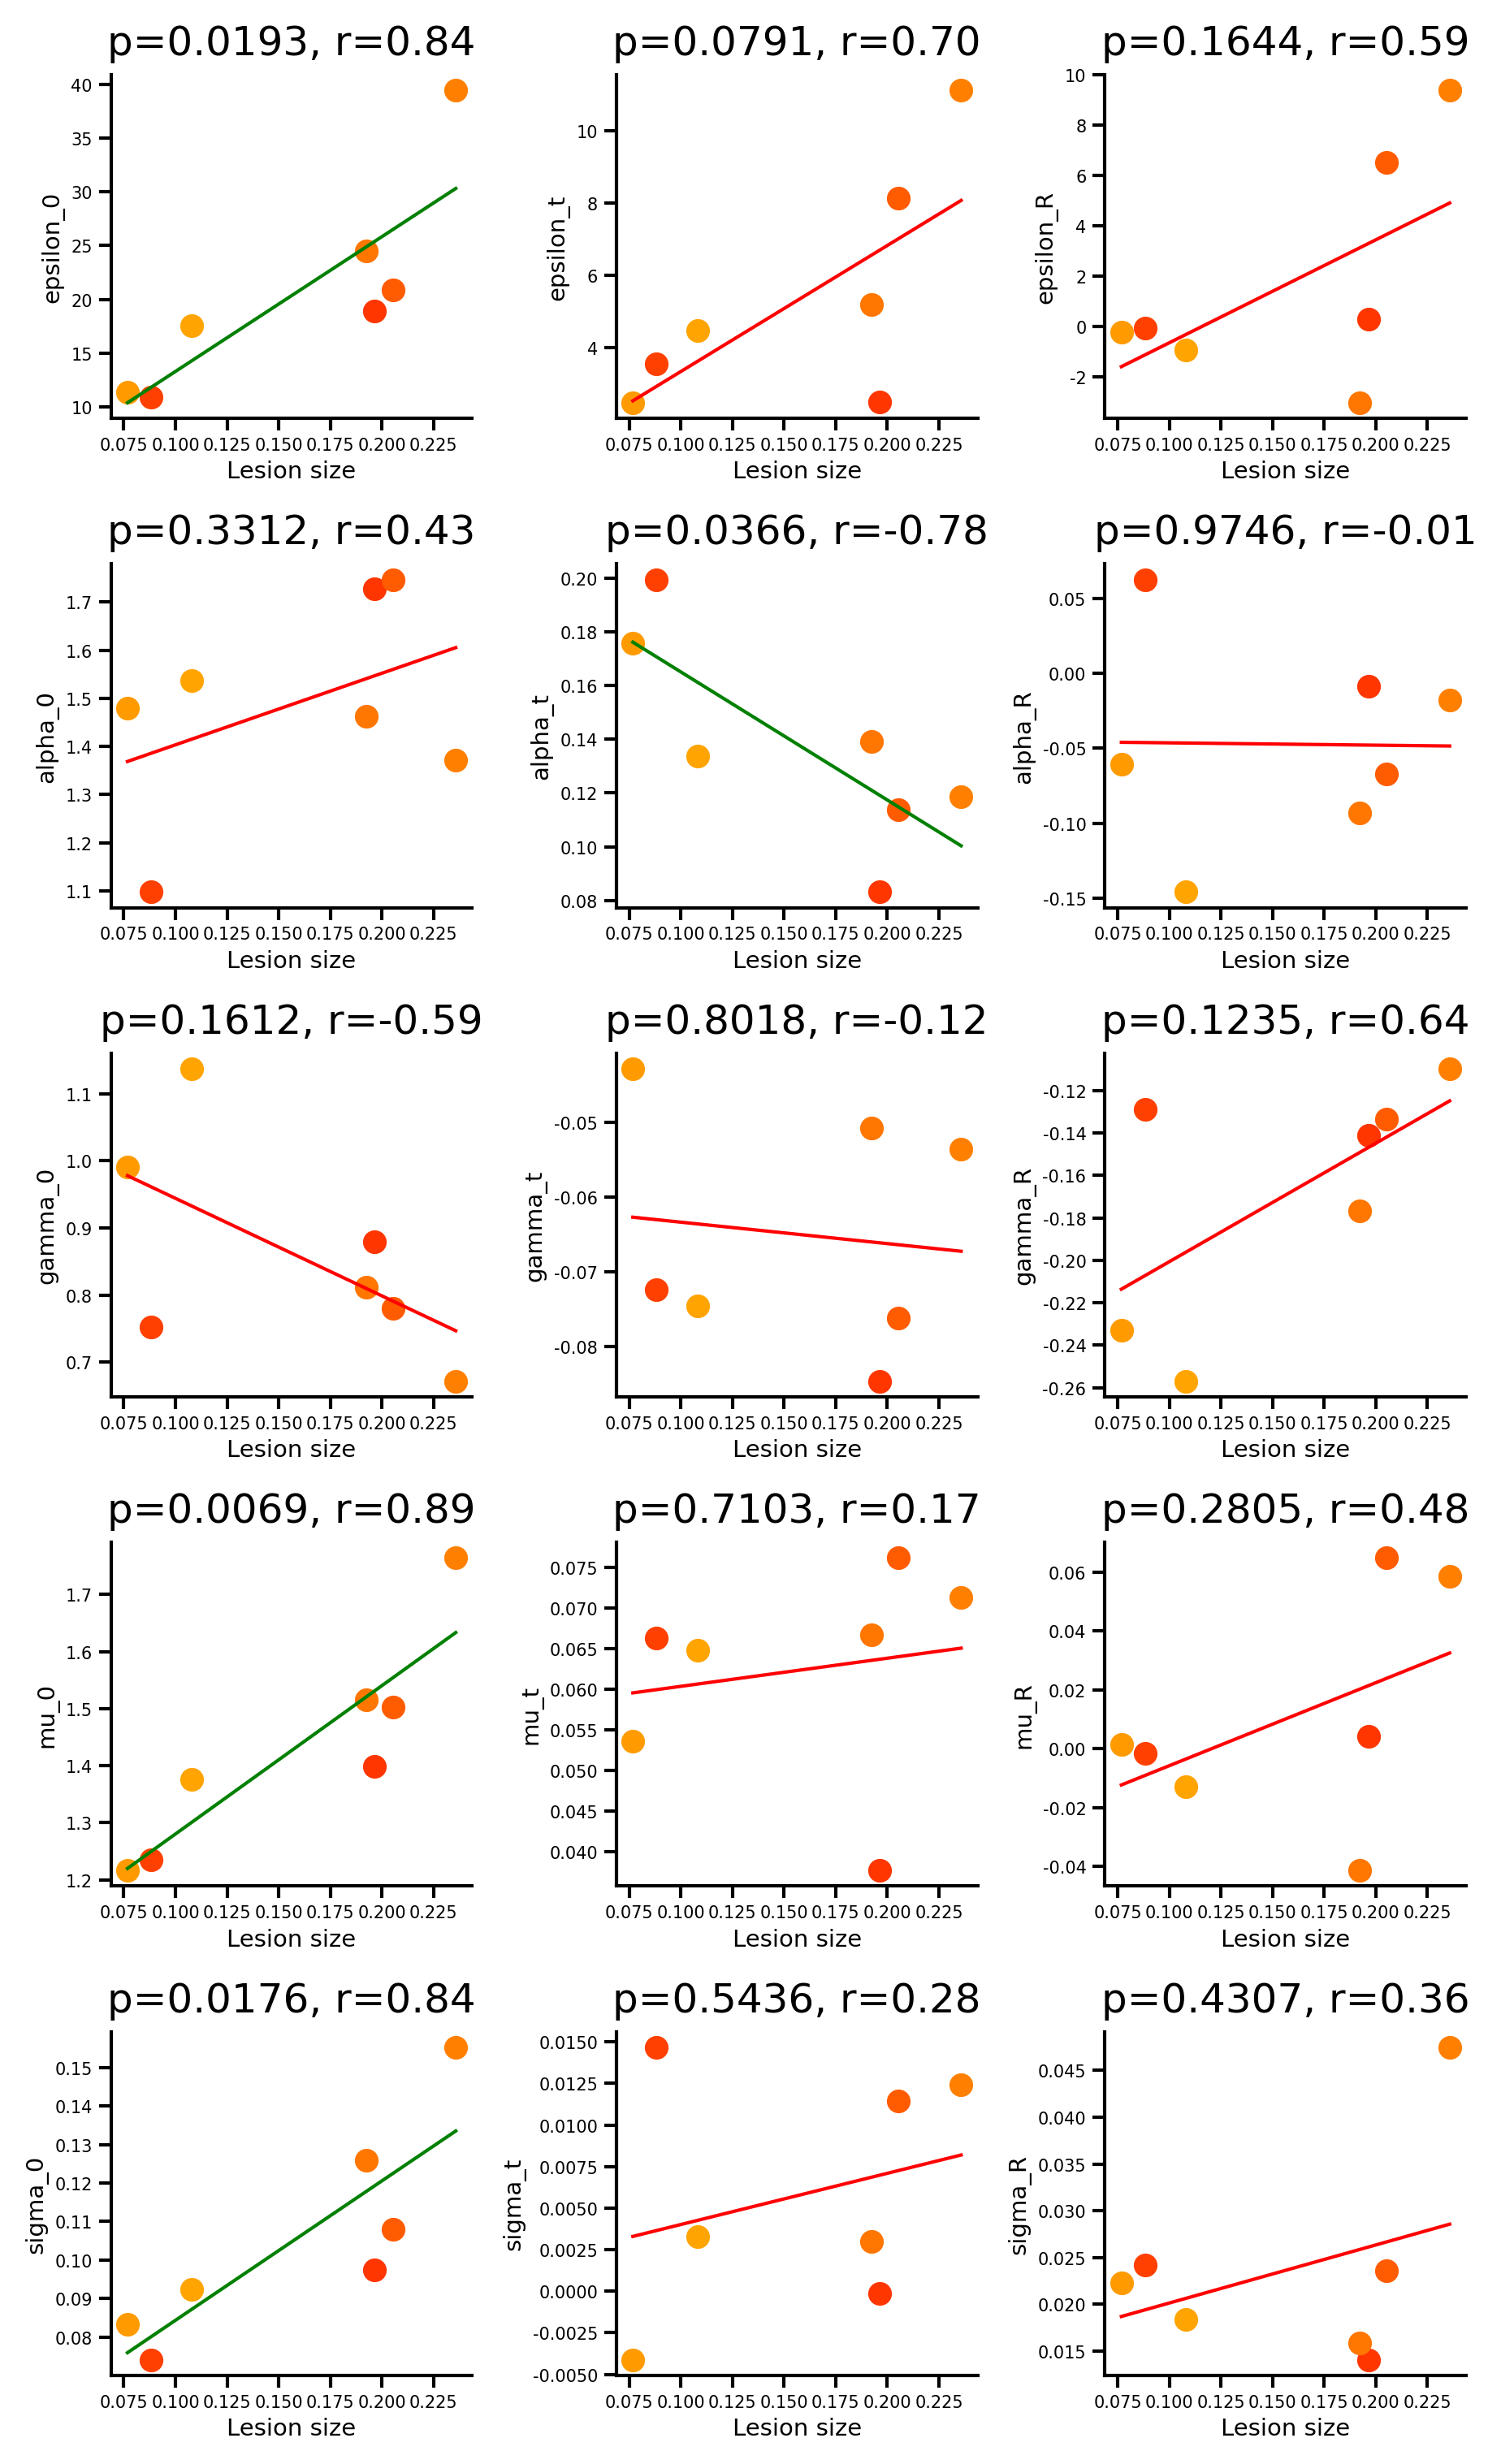

In [212]:
epsilon_0, epsilon_t, epsilon_R = pickle.load(open('picklejar/effort_fit.p', 'rb'))
alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
alpha_0 = {animal: np.mean([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
alpha_t = {animal: np.mean([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
alpha_R = {animal: np.mean([alpha_R[animal][cond] for cond in conds]) for animal in animalList}
gamma_0 = {animal: np.mean([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
gamma_t = {animal: np.mean([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
gamma_R = {animal: np.mean([gamma_R[animal][cond] for cond in conds]) for animal in animalList}
mu_0 = {animal: np.mean([mu_0[animal][cond] for cond in conds]) for animal in animalList}
mu_t = {animal: np.mean([mu_t[animal][cond] for cond in conds]) for animal in animalList}
mu_R = {animal: np.mean([mu_R[animal][cond] for cond in conds]) for animal in animalList}
sigma_0 = {animal: np.mean([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
sigma_t = {animal: np.mean([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
sigma_R = {animal: np.mean([sigma_R[animal][cond] for cond in conds]) for animal in animalList}

vars = [epsilon_0, epsilon_t, epsilon_R, alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R]
names = ['epsilon_0', 'epsilon_t', 'epsilon_R', 'alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in animalList:
        ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
        x.append(lesion_area[animal])
        y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')




In [ ]:

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in animalList:
        ax.scatter(lesion_pos[animal], var[animal], label=animal, color=rat_markers[animal][0])
        x.append(lesion_pos[animal])
        y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion pos')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')




18.90156150166412 2.49472212088463 0.2809201673484527
10.921724212105214 3.553272896594338 -0.06711416203736406
20.890112584294805 8.132972647765875 6.52306671049842
24.468282130044212 5.185705206577866 -3.047630711555846
39.4627208585808 11.105183982843043 9.392284583052824
11.343683657379188 2.480867949407441 -0.23374225402604523
17.56742504571028 4.463157640738686 -0.9383765996320443


Text(0.5, 0, 'effort sensibility parameter')

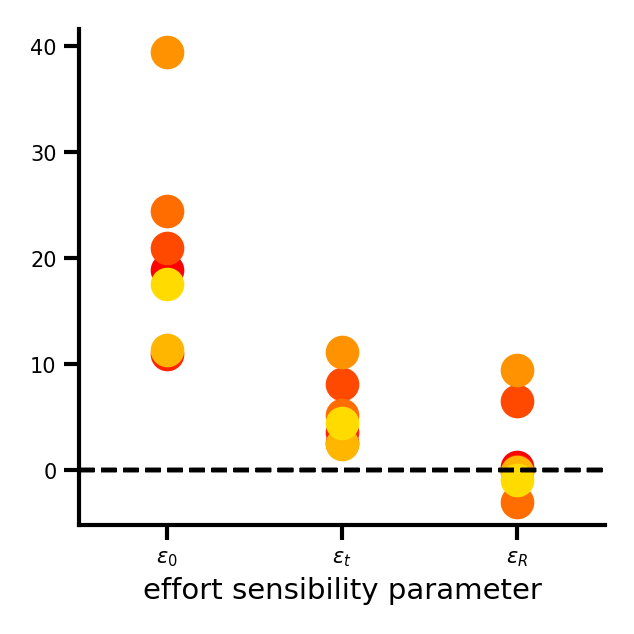

In [117]:
epsilon_0, epsilon_t, epsilon_R = pickle.load(open('picklejar/effort_fit.p', 'rb'))

fig, axs = plt.subplots(1, 1, figsize=(2, 2))
ylabels = [r'$\epsilon_0$', r"$\epsilon_t$", r"$\epsilon_R$"]
ylims = [[-.2, 2.5], [-.05, .2], [-.15, .15],]


epsilon_0_intact = []
epsilon_t_intact = []
epsilon_R_intact = []

epsilon_0_lesion = []
epsilon_t_lesion = []
epsilon_R_lesion = []

for animal in animalList:
    
    x = np.arange(3)
    epsilon_0_intact.append(epsilon_0[animal])
    epsilon_t_intact.append(epsilon_t[animal])
    epsilon_R_intact.append(epsilon_R[animal])

    print(epsilon_0[animal], epsilon_t[animal], epsilon_R[animal])
    axs.scatter(x,  [epsilon_0[animal], epsilon_t[animal], epsilon_R[animal]], color=rat_markers[animal][0], s=50)
    axs.set_title(f"")
    axs.set_xticks(np.arange(3))
    axs.set_xticklabels(ylabels)
    axs.set_xlim(-.5, 2.5)
    # axs.set_ylim(ylim)
    axs.axhline(0, color='black', linestyle='--', linewidth=1)

axs.set_xlabel("effort sensibility parameter")



In [217]:
rat_markers = {}
sequence = {}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal', 

                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'
               }

intact_map = plt.cm.get_cmap('winter')
lesion_map = plt.cm.get_cmap('autumn')

# markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
# lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}


animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatF02':
        rat_markers[animal][0] = 'k'
        
 

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32
Loading data for RatF40
Loading data for RatF41
Loading data for RatF42
Loading data for RatM40
Loading data for RatM41
Loading data for RatM42
Loading data for RatM43
Loading data for RatF50
Loading data for RatF51
Loading data for RatF52
Loading data for RatM50
Loading data for RatM51
Loading data for RatM52
Loading data for RatM53
Loading data for RatM54


# Fig params comparison intact lesion

In [248]:
alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
vars = [alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R]
names = ['alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']


import scipy.stats as stats

def compare_intact_lesion(var):
    group1 = [var[animal][cond] for cond in conds for animal in animalList if brainstatus[animal] == 'normal']
    group2 = [var[animal][cond] for cond in conds for animal in animalList if brainstatus[animal] != 'normal']

    # Check normality
    _, p_value_group1 = stats.shapiro(group1)
    _, p_value_group2 = stats.shapiro(group2)

    alpha = 0.05 
    if p_value_group1 < alpha or p_value_group2 < alpha:
        u_stat, p_value = stats.mannwhitneyu(group1, group2)

        if p_value < alpha:
            print("diff (MWU)", p_value)
        else:
            print("NO diff (MWU)", p_value)

    else:
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)

        if p_value < alpha:
            print("diff (ttest)", p_value)
        else:
            print("NO diff (ttest)", p_value)

for var, name in zip(vars, names):
    print(name)
    compare_intact_lesion(var)
    print()

alpha_0
diff (ttest) 0.003344693255320957

alpha_t
diff (MWU) 3.3549750257642545e-05

alpha_R
NO diff (MWU) 0.897197142303075

gamma_0
NO diff (ttest) 0.997696452394409

gamma_t
NO diff (MWU) 0.49577188907824876

gamma_R
NO diff (MWU) 0.4388223029870496

mu_0
diff (MWU) 0.00013274819118357878

mu_t
NO diff (MWU) 0.06122170303428324

mu_R
NO diff (MWU) 0.30862167000791174

sigma_0
diff (MWU) 0.016624717360482474

sigma_t
NO diff (MWU) 0.05705365330721336

sigma_R
NO diff (MWU) 0.05841596484084364



In [252]:
epsilon_0, epsilon_t, epsilon_R = pickle.load(open('picklejar/effort_fit.p', 'rb'))
alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
alpha_0 = {animal: np.mean([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
alpha_t = {animal: np.mean([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
alpha_R = {animal: np.mean([alpha_R[animal][cond] for cond in conds]) for animal in animalList}
gamma_0 = {animal: np.mean([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
gamma_t = {animal: np.mean([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
gamma_R = {animal: np.mean([gamma_R[animal][cond] for cond in conds]) for animal in animalList}
mu_0 = {animal: np.mean([mu_0[animal][cond] for cond in conds]) for animal in animalList}
mu_t = {animal: np.mean([mu_t[animal][cond] for cond in conds]) for animal in animalList}
mu_R = {animal: np.mean([mu_R[animal][cond] for cond in conds]) for animal in animalList}
sigma_0 = {animal: np.mean([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
sigma_t = {animal: np.mean([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
sigma_R = {animal: np.mean([sigma_R[animal][cond] for cond in conds]) for animal in animalList}

vars = [epsilon_0, epsilon_t, epsilon_R, alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R]
names = ['epsilon_0', 'epsilon_t', 'epsilon_R', 'alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']


epsilon_0 0.0096
epsilon_t 0.3792
epsilon_R 0.3072


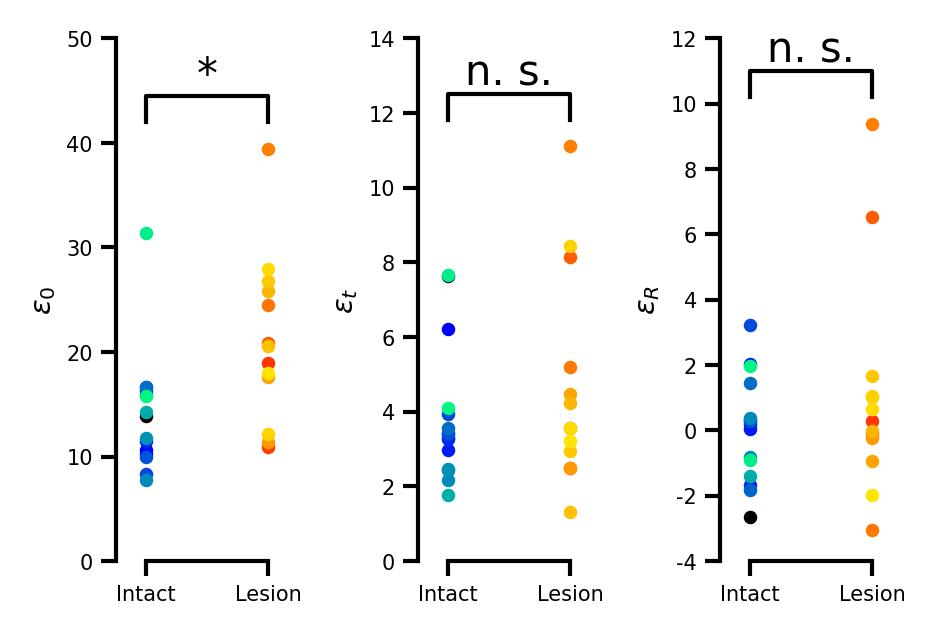

In [253]:
def Figure6_A(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(epsilon_0[animal])
            x = 0
        else:
            lesion.append(epsilon_0[animal])
            x = 1
        ax.scatter(x, epsilon_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 50)
    ax.set_ylabel(r'$\epsilon_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("epsilon_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_B(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(epsilon_t[animal])
            x = 0
        else:
            lesion.append(epsilon_t[animal])
            x = 1
        ax.scatter(x, epsilon_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 14)
    ax.set_ylabel(r'$\epsilon_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("epsilon_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_C(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(epsilon_R[animal])
            x = 0
        else:
            lesion.append(epsilon_R[animal])
            x = 1
        ax.scatter(x, epsilon_R[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-4, 12)
    ax.set_ylabel(r'$\epsilon_R$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("epsilon_R", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_A(axs[0])
Figure6_B(axs[1])
Figure6_C(axs[2])

alpha_0 0.1441
alpha_t 0.0378
alpha_R 0.9341


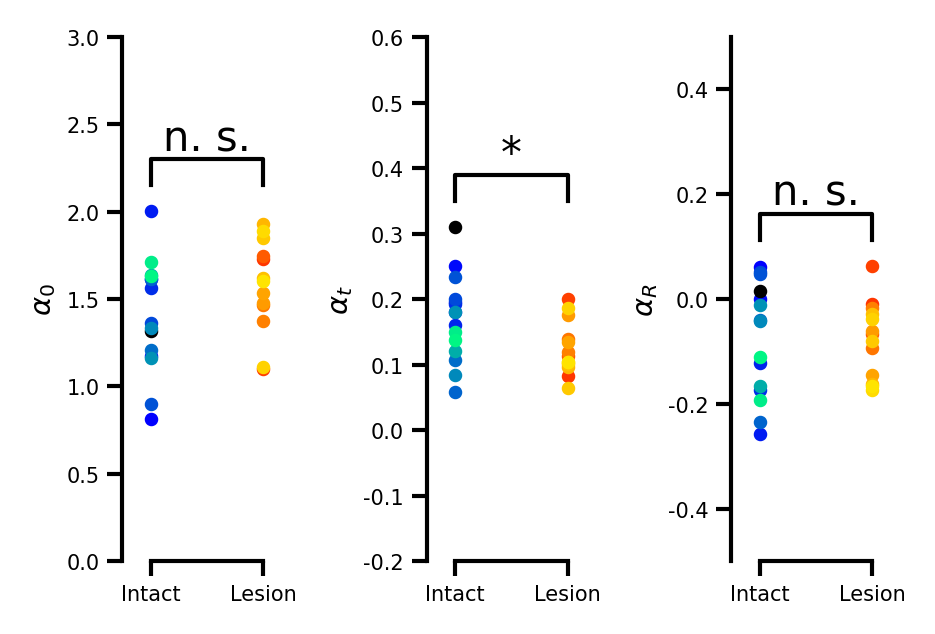

In [254]:
def Figure6_D(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(alpha_0[animal])
            x = 0
        else:
            lesion.append(alpha_0[animal])
            x = 1
        ax.scatter(x, alpha_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("alpha_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_E(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(alpha_t[animal])
            x = 0
        else:
            lesion.append(alpha_t[animal])
            x = 1
        ax.scatter(x, alpha_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.2, .6)
    ax.set_ylabel(r'$\alpha_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("alpha_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(alpha_R[animal])
            x = 0
        else:
            lesion.append(alpha_R[animal])
            x = 1
        ax.scatter(x, alpha_R[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.5, .5)
    ax.set_ylabel(r'$\alpha_R$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("alpha_R", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_D(axs[0])
Figure6_E(axs[1])
Figure6_F(axs[2])

gamma_0 0.9994
gamma_t 0.8286
gamma_R 0.952


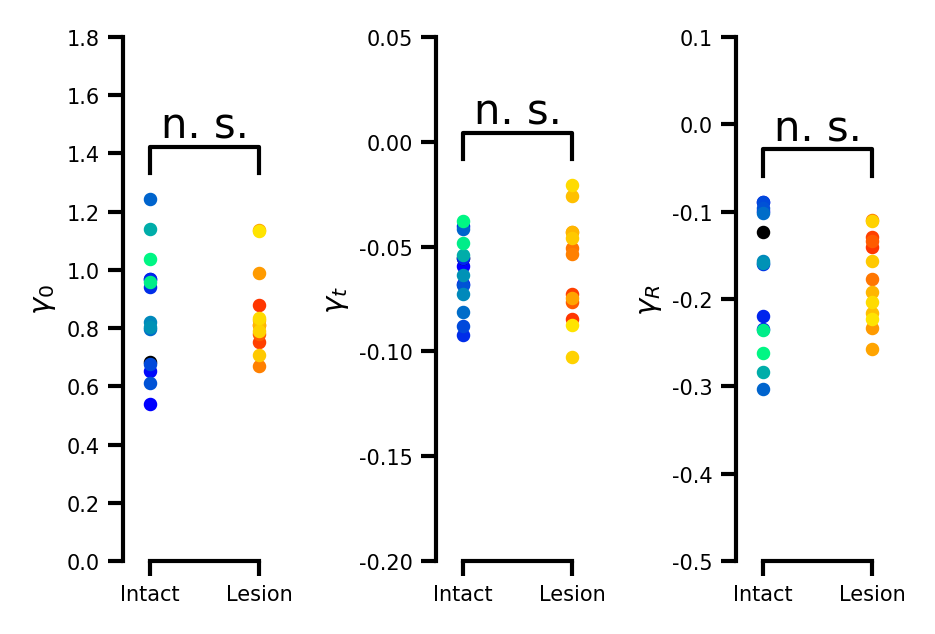

In [255]:
def Figure6_G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(gamma_0[animal])
            x = 0
        else:
            lesion.append(gamma_0[animal])
            x = 1
        ax.scatter(x, gamma_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.8)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("gamma_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)


def Figure6_H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(gamma_t[animal])
            x = 0
        else:
            lesion.append(gamma_t[animal])
            x = 1
        ax.scatter(x, gamma_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.2, 0.05)
    ax.set_ylabel(r'$\gamma_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("gamma_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(gamma_R[animal])
            x = 0
        else:
            lesion.append(gamma_R[animal])
            x = 1
        ax.scatter(x, gamma_R[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, .1)
    ax.set_ylabel(r'$\gamma_R$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("gamma_R", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_G(axs[0])
Figure6_H(axs[1])
Figure6_I(axs[2])

sigma_0 0.1297
sigma_t 0.3665
sigma_R 0.5388


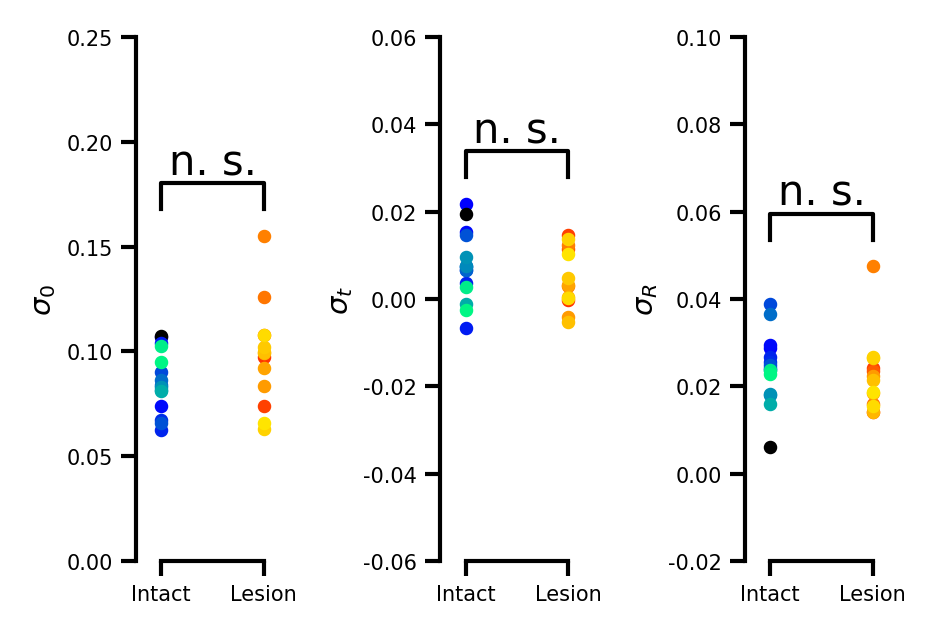

In [256]:
def Figure6_G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(sigma_0[animal])
            x = 0
        else:
            lesion.append(sigma_0[animal])
            x = 1
        ax.scatter(x, sigma_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, .25)
    ax.set_ylabel(r'$\sigma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("sigma_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)


def Figure6_H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(sigma_t[animal])
            x = 0
        else:
            lesion.append(sigma_t[animal])
            x = 1
        ax.scatter(x, sigma_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.06, 0.06)
    ax.set_ylabel(r'$\sigma_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("sigma_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(sigma_R[animal])
            x = 0
        else:
            lesion.append(sigma_R[animal])
            x = 1
        ax.scatter(x, sigma_R[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, .1)
    ax.set_ylabel(r'$\sigma_R$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("sigma_R", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_G(axs[0])
Figure6_H(axs[1])
Figure6_I(axs[2])

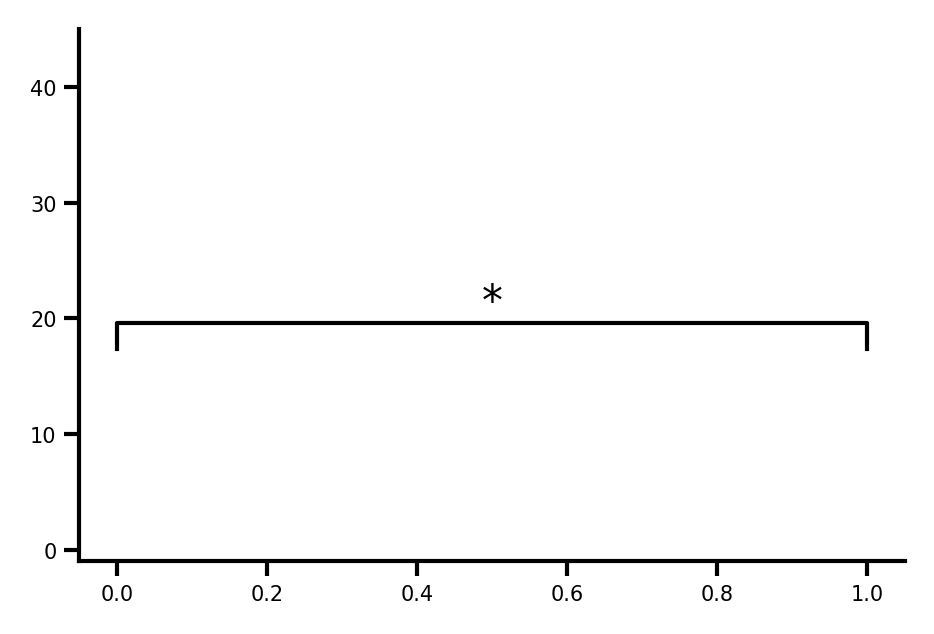

In [257]:
def barplot_annotate_brackets(ax, num1, num2, data, center, height, dh=.05, barh=.05, fs=None, maxasterix=3):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    ax_y0, ax_y1 = ax.get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)

    

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.set_ylim(-1, 45)
barplot_annotate_brackets(ax, 0, 1, 0.005, [0, 1, 0], [10, 15, 0], maxasterix=3)

epsilon_0 corr: 0.84, p: 0.0193
epsilon_t corr: 0.70, p: 0.0791
epsilon_R corr: 0.59, p: 0.1644
alpha_0 corr: 0.43, p: 0.3312
alpha_t corr: -0.78, p: 0.0366
alpha_R corr: -0.01, p: 0.9746
gamma_0 corr: -0.59, p: 0.1612
gamma_t corr: -0.12, p: 0.8018
gamma_R corr: 0.64, p: 0.1235
mu_0 corr: 0.89, p: 0.0069
mu_t corr: 0.17, p: 0.7103
mu_R corr: 0.48, p: 0.2805
sigma_0 corr: 0.84, p: 0.0176
sigma_t corr: 0.28, p: 0.5436
sigma_R corr: 0.36, p: 0.4307


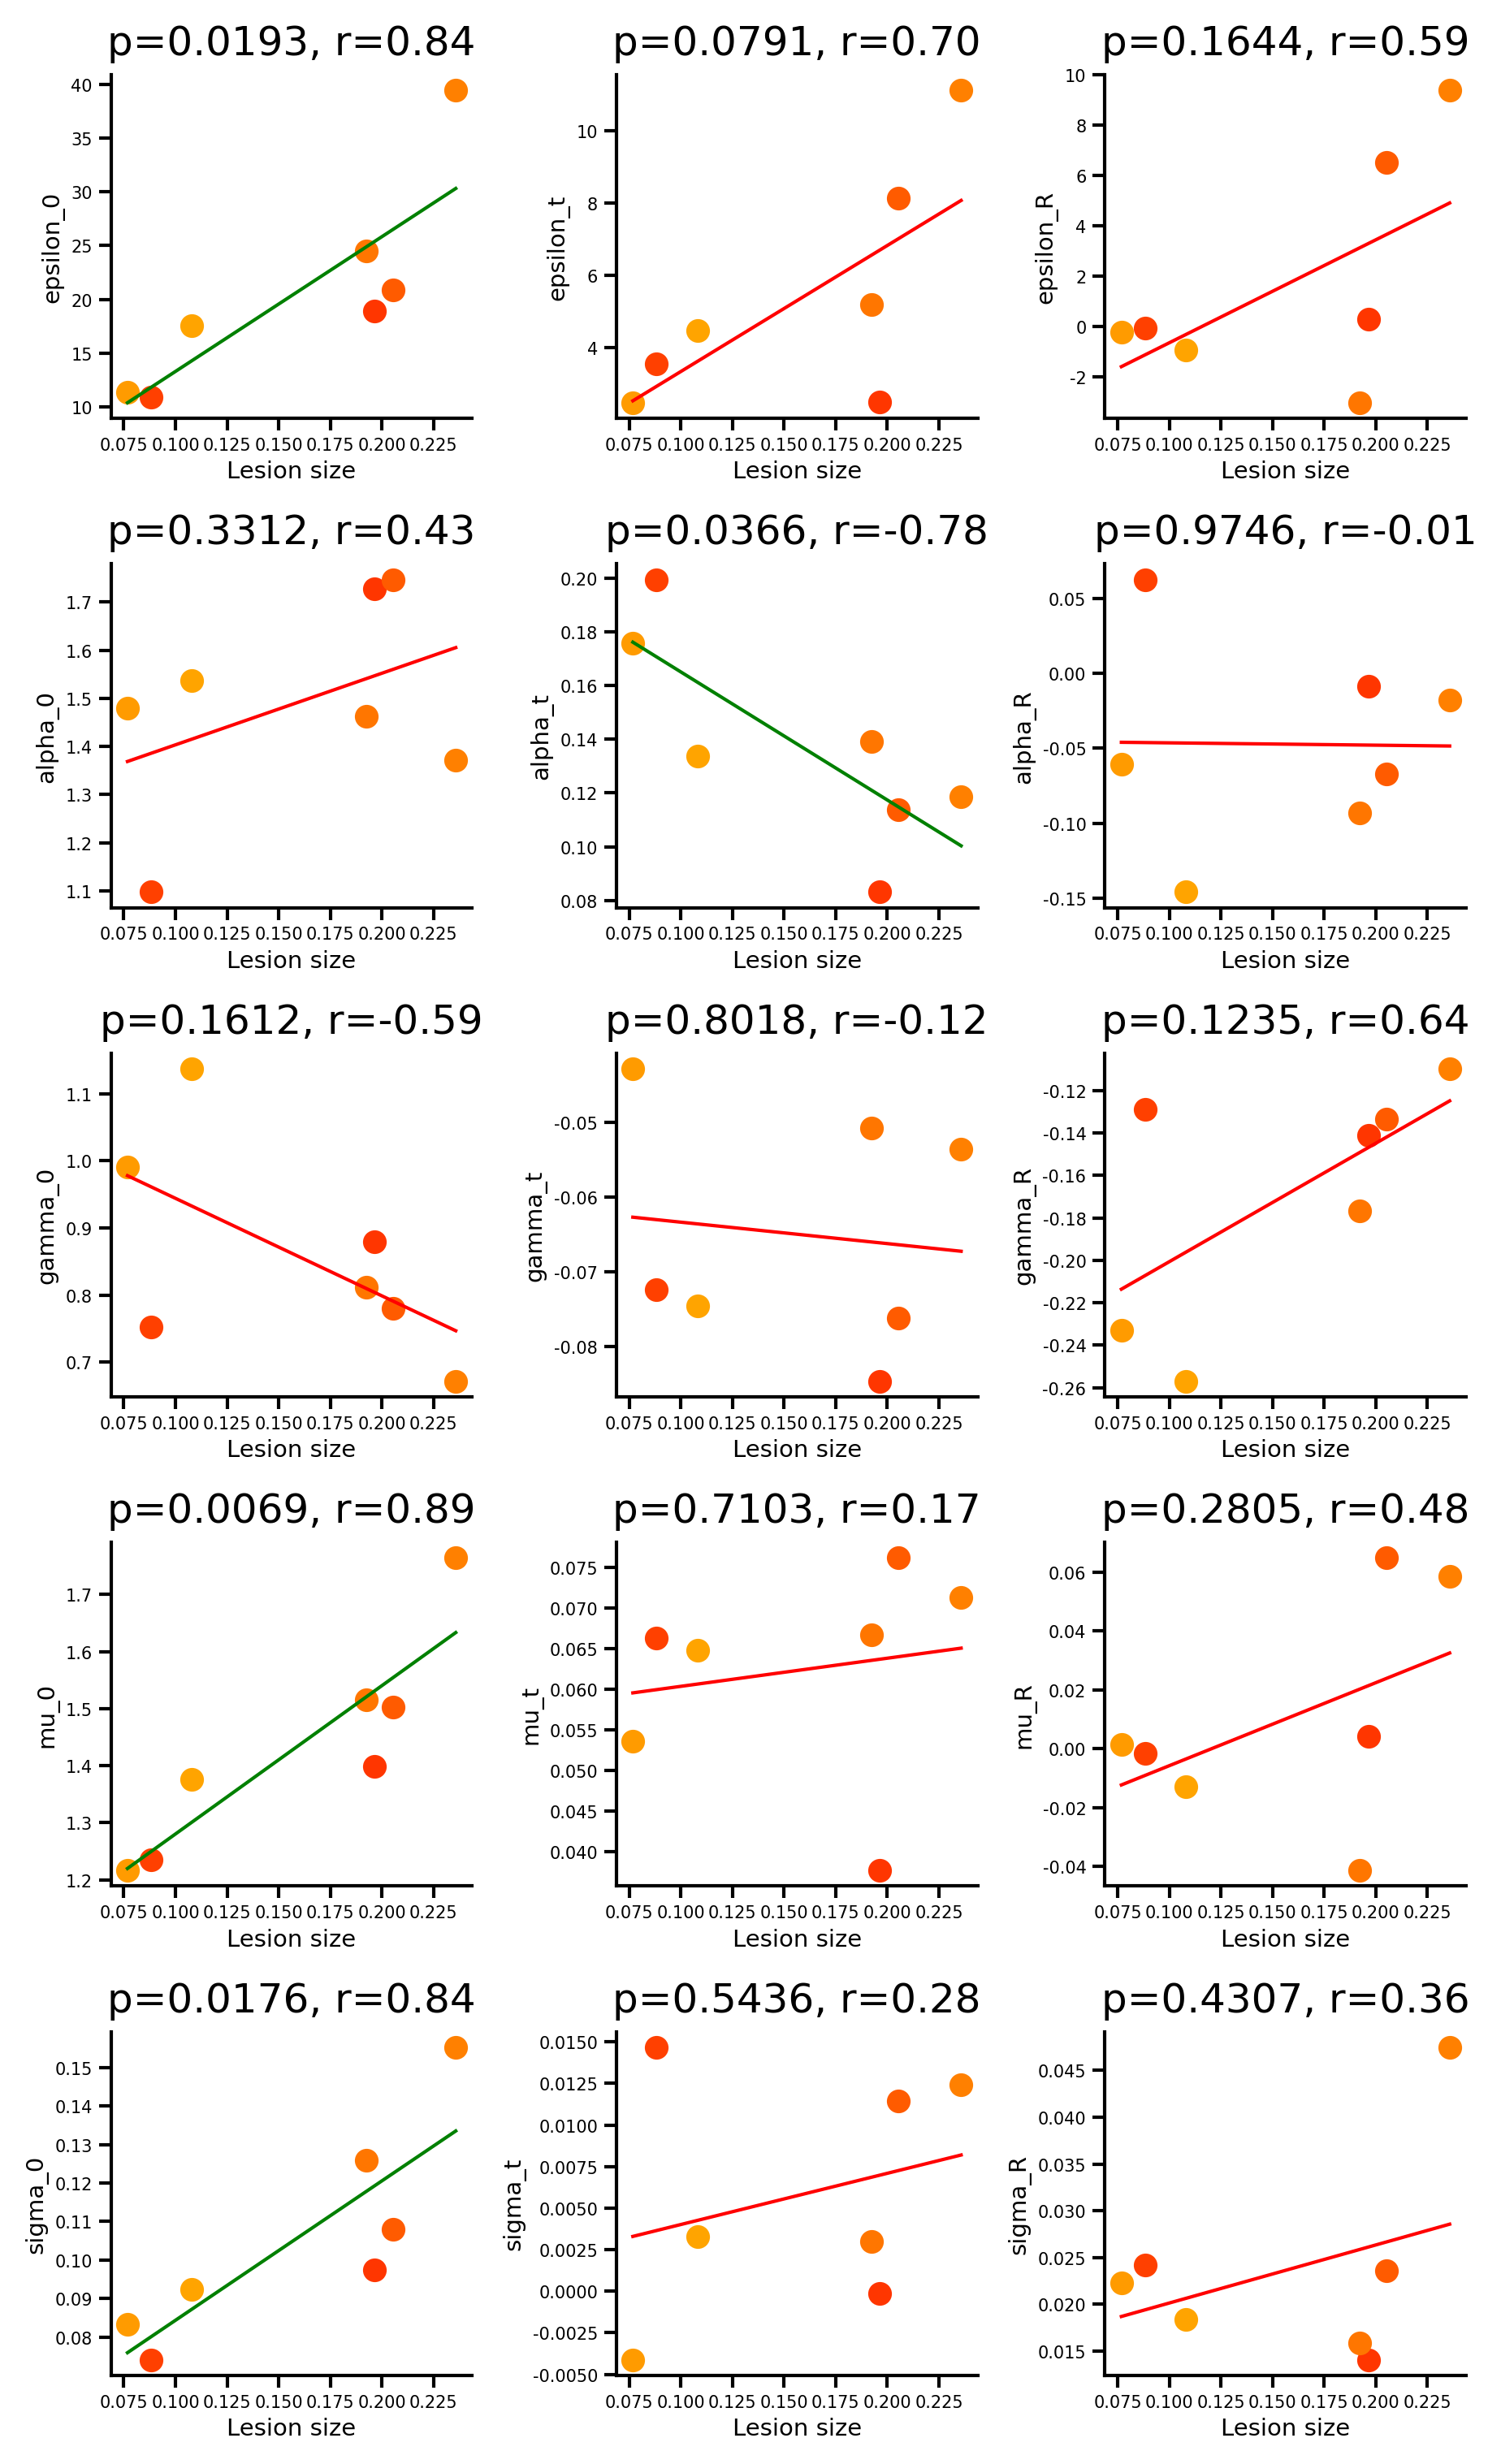

In [263]:
conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']

alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

_alpha_0 = {animal: np.mean([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
_alpha_t = {animal: np.mean([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
_alpha_R = {animal: np.mean([alpha_R[animal][cond] for cond in conds]) for animal in animalList}
_gamma_0 = {animal: np.mean([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
_gamma_t = {animal: np.mean([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
_gamma_R = {animal: np.mean([gamma_R[animal][cond] for cond in conds]) for animal in animalList}
_mu_0 = {animal: np.mean([mu_0[animal][cond] for cond in conds]) for animal in animalList}
_mu_t = {animal: np.mean([mu_t[animal][cond] for cond in conds]) for animal in animalList}
_mu_R = {animal: np.mean([mu_R[animal][cond] for cond in conds]) for animal in animalList}
_sigma_0 = {animal: np.mean([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
_sigma_t = {animal: np.mean([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
_sigma_R = {animal: np.mean([sigma_R[animal][cond] for cond in conds]) for animal in animalList}

vars = [epsilon_0, epsilon_t, epsilon_R, _alpha_0, _alpha_t, _alpha_R, _gamma_0, _gamma_t, _gamma_R, _mu_0, _mu_t, _mu_R, _sigma_0, _sigma_t, _sigma_R]
names = ['epsilon_0', 'epsilon_t', 'epsilon_R', 'alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in animalList:
        if animal in lesion_area.keys():
            ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
            x.append(lesion_area[animal])
            y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')

epsilon_0 corr: 0.84, p: 0.0193
epsilon_t corr: 0.70, p: 0.0791
epsilon_R corr: 0.59, p: 0.1644
alpha_0 corr: 0.43, p: 0.3312
alpha_t corr: -0.78, p: 0.0366
alpha_R corr: -0.01, p: 0.9746
gamma_0 corr: -0.59, p: 0.1612
gamma_t corr: -0.12, p: 0.8018
gamma_R corr: 0.64, p: 0.1235
mu_0 corr: 0.89, p: 0.0069
mu_t corr: 0.17, p: 0.7103
mu_R corr: 0.48, p: 0.2805
sigma_0 corr: 0.84, p: 0.0176
sigma_t corr: 0.28, p: 0.5436
sigma_R corr: 0.36, p: 0.4307


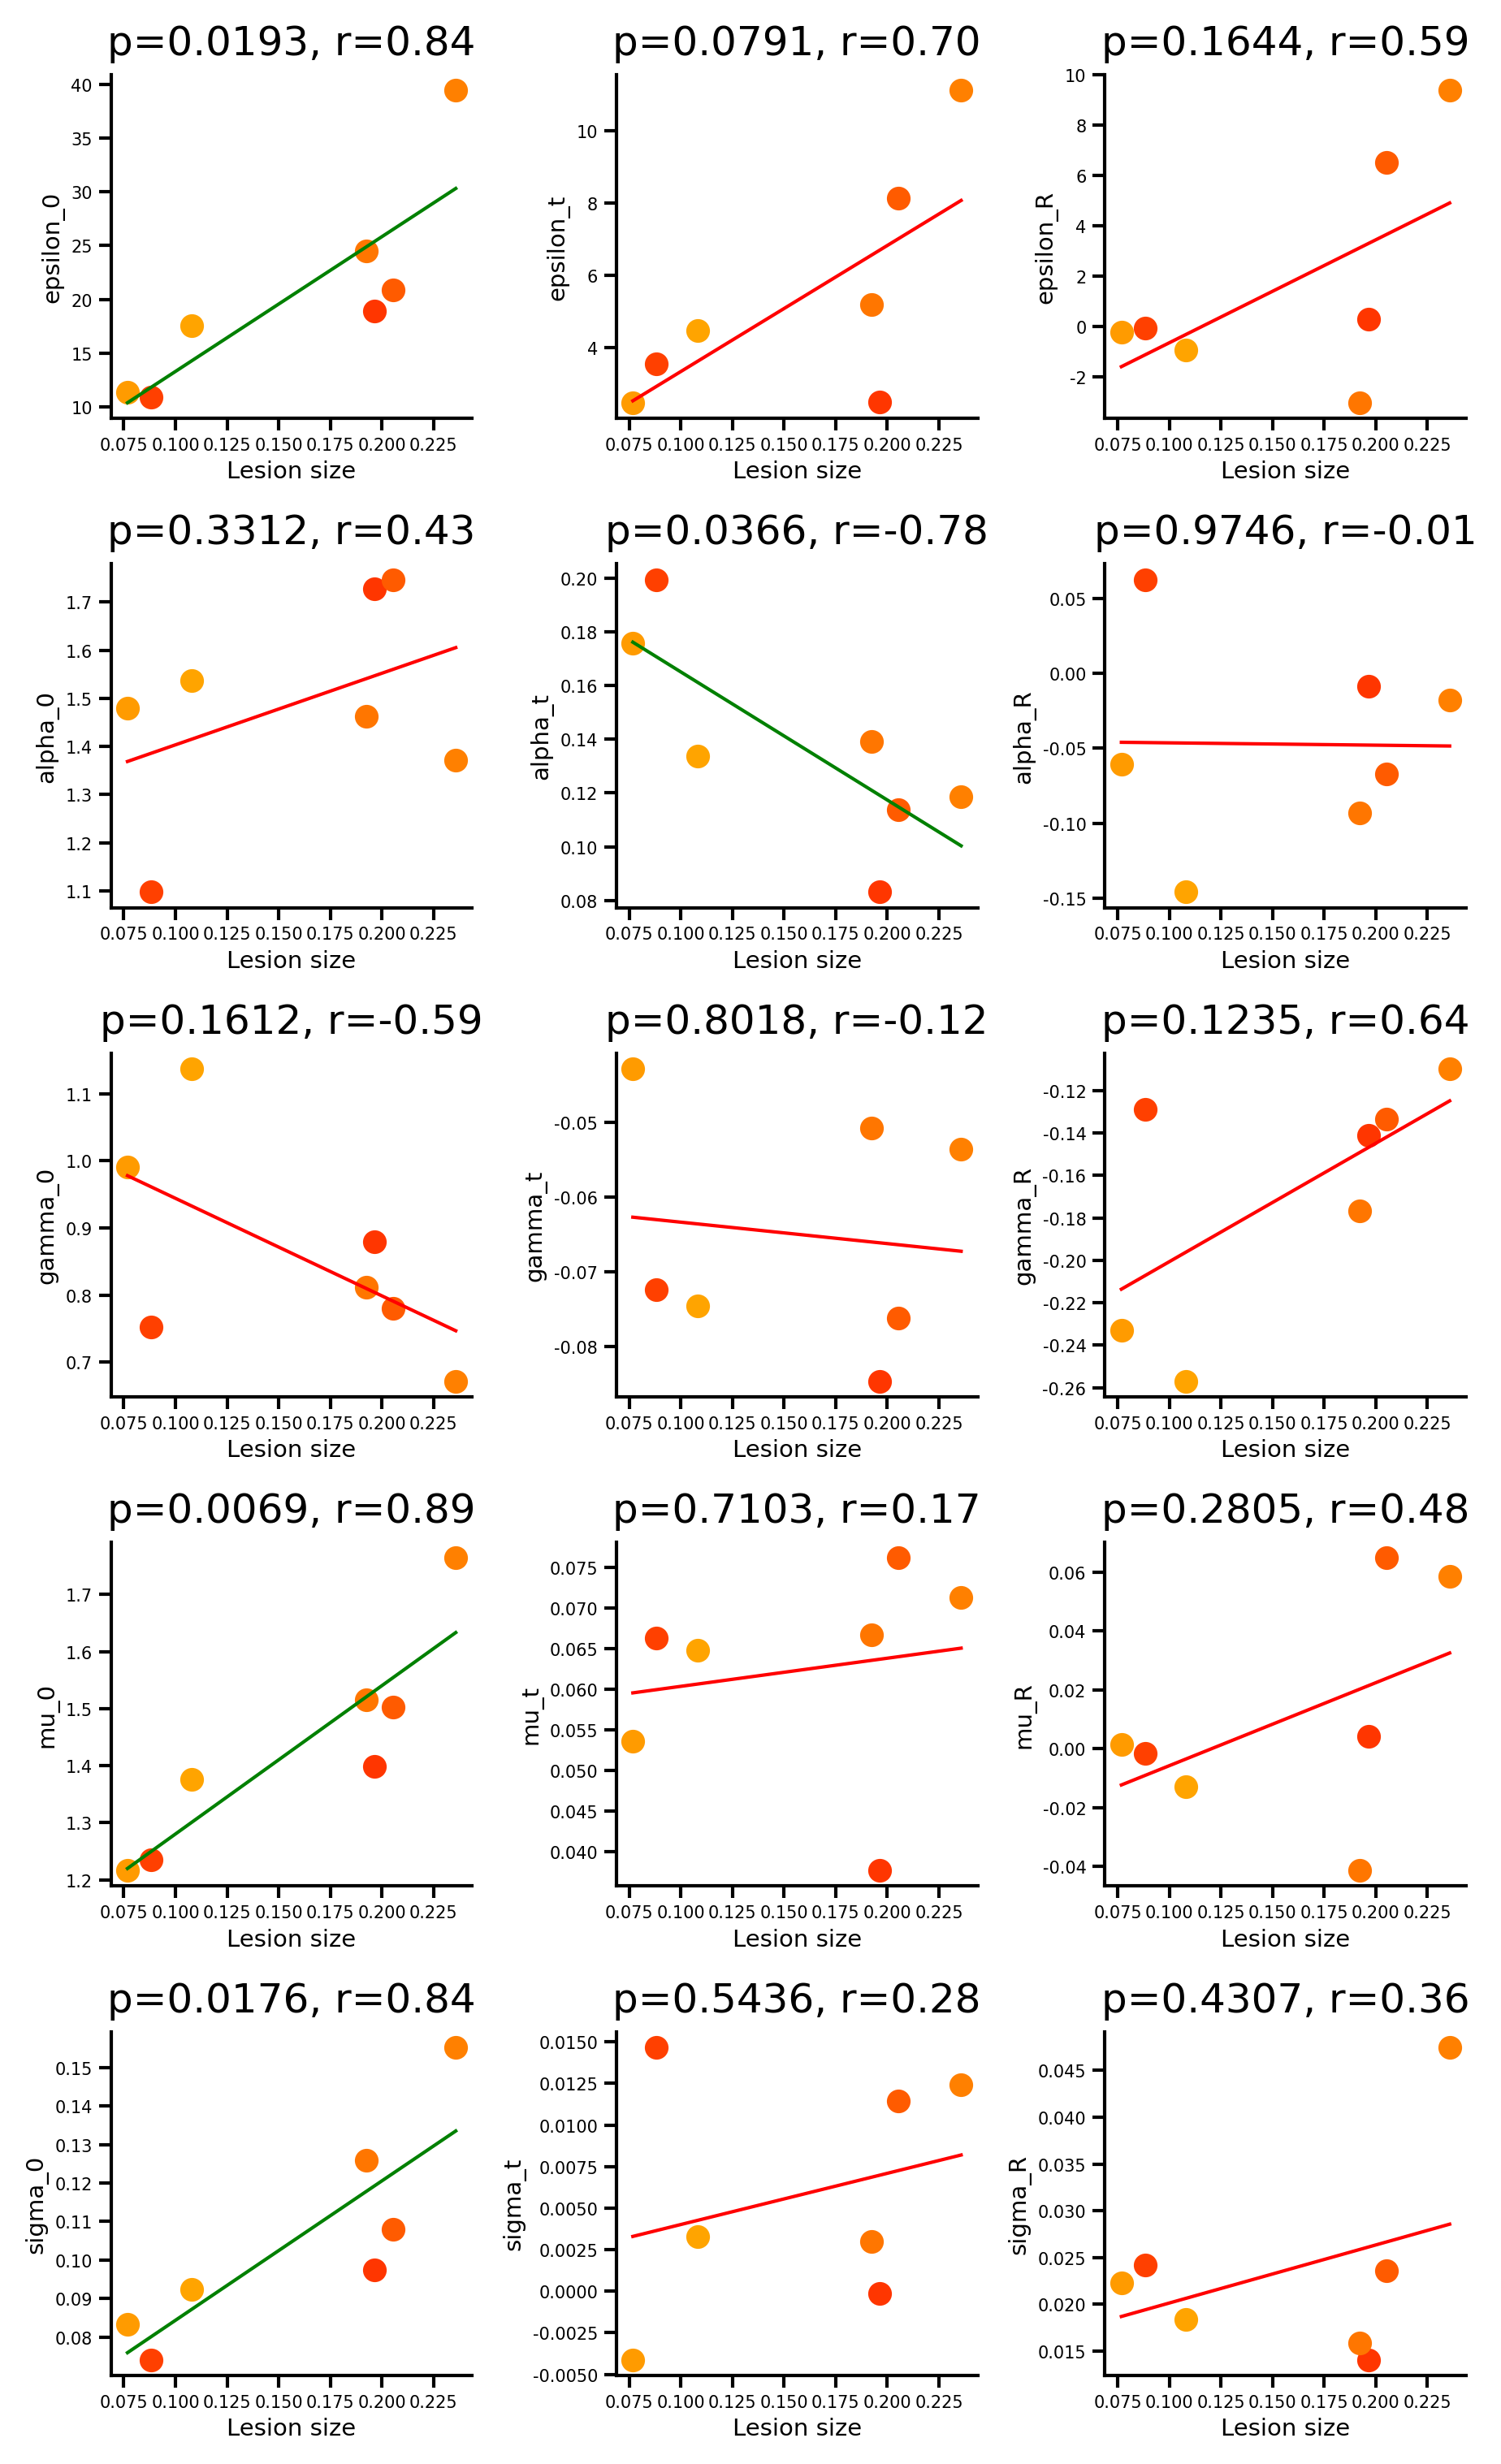

In [264]:

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in animalList:
        if animal in lesion_area.keys():
            ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
            x.append(lesion_area[animal])
            y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')